<h1 style='text-align: center'>ISFA - M2 ES - EQUADE</h1>
<h4 style='text-align: center; margin-top:1%'>APPRENTISSAGE STATISTIQUE ET INTELLIGENCE ARTIFICIELLE : RESEAUX DE NEURONE</h4>
<h4 style='text-align: center; margin-top:1%'></h4>
<h1 style='text-align: center; margin-top:1%'><b>NLP - Phrase textuelle et implication <b> </h1>
<h4 style='text-align: center; margin-top:1%'></h4>
<h4 style='text-align: center; margin-top:1%'>Students: Crésus KOUNOUDJI</h4>
<h4 style='text-align: center; margin-top:1%'></h4>
<h4 style='text-align: center; margin-top:1%'>Professor: Esterina MASIELLO</h4>

<h1 style='text-align: center'> Les données:</h1>

<br><br>
Les données utilisée sont representée par une table de pairs de test avec etiquettage des implications ("implication","contradiction" ou "neutre") et un score de parentée. Elles sont issue de la table SICK dataset (NLP - Sentence Textual Similarity) sur <a href='https://www.kaggle.com/datasets/ozgeozkaya/sick-dataset?resource=download' target='_blank'>Kaggle : SICK dataset</a>. 
<br><br>

<b>Description de l'ensemble de données :</b>

- 'pairs_ID': Il s'agit d'un identifiant unique pour chaque paire de phrases dans la base de données.
- 'sentence_A': Cette colonne contient la première phrase de la paire.
- 'sentence_B': Cette colonne contient la deuxième phrase de la paire.
- 'relatedness_score': Il s'agit d'un score de proximité entre les phrases A et B, qui mesure leur similarité sémantique. Le score est compris entre 1 et 5, où 1 indique une faible similarité sémantique et 5 une forte similarité.
- 'entailment_judgment': Cette colonne indique si la phrase A implique, contredit ou n'a aucun lien avec la phrase B ("entailment", "contradiction" ou "neutral").

Je n'ai aucune information sur la construction et la création de la base mais de ce que j'ai pu lire, la colonne 'relatedness_score' est probablement calculée en utilisant des techniques de modélisation de langage naturel avancées (Word2Vec, GloVe ou BERT,etc.) qui permettent de capturer la signification sémantique des phrases en fonction de leur contexte.

<b>

</b>

Résumé :


Dans ce script, on utilise des modèles LSTM et CNN pour classer des paires de phrases en tant que "ENTAILMENT" ou "NEUTRAL" ou "CONTRADICTION". On utilise pour cela des techniques de NLP telles que la tokenisation, le paddage de séquences et l'entraînement avec des labels "ENTAILMENT" ou "NEUTRAL" ou "CONTRADICTION". On effectue ensuite une k-fold cross-validation pour évaluer la performance des modèles, puis on affiche les matrices de confusion et un graphique comparant les performances des deux modèles. Enfin, on entraîne et évalue ensuite le meilleur modèle (LSTM) sur l'ensemble de test et  on affiche les graphiques de loss et accuracy par epoch pour chaque modèle.

Conclusion:
Les performances du modèle CNN sont un peu meilleures et plus cohérentes que celles de LSTM à priori. La cohérence du modèle LSTM dépends beaucoup du paramètre n_split du K-fold.

### Importation de paquets utiles

In [16]:
import os
#for handling data frames among other things
import pandas as pd
import numpy as np
#visualisation graphique
import matplotlib.pyplot as plt
import seaborn as sns
#modèle LSTM et CNN
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
#matrice de confusion
from sklearn.metrics import f1_score, confusion_matrix
from keras.utils import to_categorical

#### Dossier de stockage de données

In [17]:
# Créer les dossier de sortie s'ils n'existent pas :
input_data = "data_nlp/"
output_data = "output_nlp/"
if not os.path.exists(output_data):
    os.makedirs(output_data)

### I- Chargement, exploration et traitement de données (si besoin)

#### 1.1- chargement et aperçu de la base de données  (fichier textuelle)

In [18]:
##importation des données :
data = pd.read_csv(input_data+"SICK_train.txt",sep="\t")
#paramètres de la base :
print("la base est constituée des colonnes : ", data.columns)
#taille de la base :
print("la base est constituée : ", data.shape[0], "lignes")
#aperçu des données dans la base :
data.head()

la base est constituée des colonnes :  Index(['pair_ID', 'sentence_A', 'sentence_B', 'relatedness_score',
       'entailment_judgment'],
      dtype='object')
la base est constituée :  4500 lignes


,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


In [19]:
#aperçu complet des deux version d'une même phrase dans la table de données :
print("La version A est : ", data.iloc[1,1])
print("La version B est : ", data.iloc[1,2])
print("Ces deux phrases ont un score de parenté de : ", data.iloc[1,3])
print("Le jugement de l'implication est : ", data.iloc[1,4])

La version A est :  A group of children is playing in the house and there is no man standing in the background
La version B est :  A group of kids is playing in a yard and an old man is standing in the background
Ces deux phrases ont un score de parenté de :  3.2
Le jugement de l'implication est :  NEUTRAL


#### 1.2- analyse exporatoire des données

Il s'agit d'analyser les valeurs aberrantes pour comprendre pourquoi elles sont différentes de la moyenne et voir si elles des résultats valides mais inattendus ou des erreurs de prédiction qui peuvent biaisés les estimations. Ainsi, on pourra ajuster les hyperparamètres pour avoir des modèles performant, en collectant plus de données d'entraînement ou en utilisant un algorithme différent. Si elles sont des résultats valides mais inattendus on peut regarder pourquoi ces cas sont différents et comment vous pouvez les traiter différemment pour améliorer les performances.

Mais en règle général, on lutilise des ensembles de modèles, où plusieurs modèles ensemble pour améliorer les performances et réduire l'impact des valeurs aberrantes. 

#### 1.2.a - Distribution de la variable de Jugement de l'implication

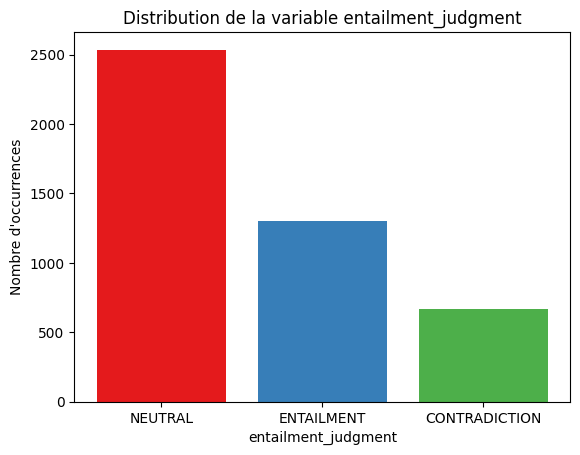

In [20]:
#Distribution de la variable entailment_judgment
counts = data['entailment_judgment'].value_counts()
num_modalities = len(counts)
# Créer une palette de couleurs en fonction du nombre de modalités
colors = plt.cm.Set1(range(num_modalities))
# Créer un graphique à barres empilées
plt.bar(counts.index, counts.values, color=colors)
plt.xlabel('entailment_judgment')
plt.ylabel('Nombre d\'occurrences')
plt.title('Distribution de la variable entailment_judgment')
plt.savefig(f"{output_data}dist_judgment.png")
plt.show()

les modalités "contradiction" son relativement mal représentée dans la base ce qui fait que selon la répartition des base "test" et "train" on peut avoir un nombre différent de modalité dans chaque groupe.

#### 1.2.b - Distribution de la variable score de parenté

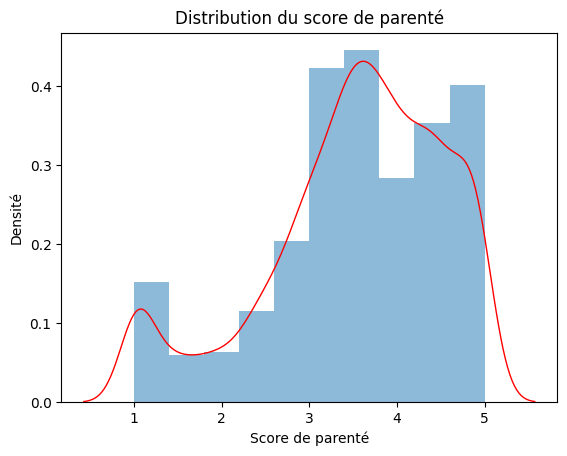

In [21]:
#Distribution de la variable score de parenté "relatedness_score" :
# Tracer un histogramme avec la densité
plt.hist(data['relatedness_score'], density=True, alpha=0.5)
# Tracer une estimation de densité kernel
sns.kdeplot(data['relatedness_score'], color='r', linewidth=1)
# Ajouter des titres et des labels
plt.xlabel('Score de parenté')
plt.ylabel('Densité')
plt.title('Distribution du score de parenté')
plt.savefig(f"{output_data}dist_score.png")
plt.show()

#### 1.2.c Distribution de la variable score de parenté par Jugement de l'implication 

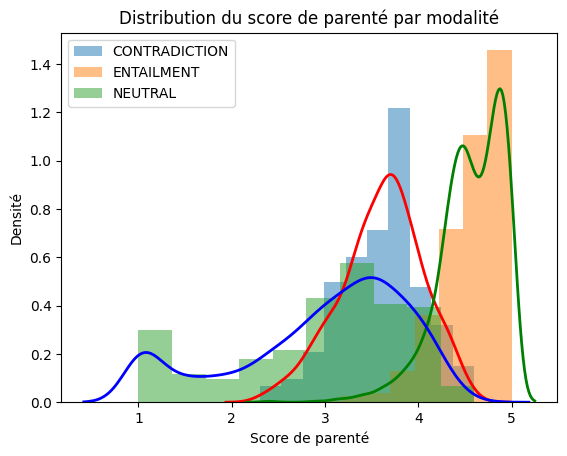

In [22]:
# Séparer les données par modalité de 'entailment_judgment'
contradiction = data[data['entailment_judgment'] == 'CONTRADICTION']
entailment = data[data['entailment_judgment'] == 'ENTAILMENT']
neutral = data[data['entailment_judgment'] == 'NEUTRAL']

# Tracer un histogramme pour chaque modalité avec la densité
plt.hist(contradiction['relatedness_score'], density=True, alpha=0.5, label='CONTRADICTION')
plt.hist(entailment['relatedness_score'], density=True, alpha=0.5, label='ENTAILMENT')
plt.hist(neutral['relatedness_score'], density=True, alpha=0.5, label='NEUTRAL')

# Tracer une estimation de densité kernel pour chaque modalité
sns.kdeplot(contradiction['relatedness_score'], color='r', linewidth=2)
sns.kdeplot(entailment['relatedness_score'], color='g', linewidth=2)
sns.kdeplot(neutral['relatedness_score'], color='b', linewidth=2)

# Ajouter des titres et des labels
plt.xlabel('Score de parenté')
plt.ylabel('Densité')
plt.title('Distribution du score de parenté par modalité')
plt.legend()
plt.savefig(f"{output_data}dist_score_byjudgment.png")
plt.show()


Les score ont une disbution assez différente d'une classe à l'autre et sont globalement étalées sur la gauche. Il faudra garder cette hétérogéneité dans les classes et cette assymétrie dans les données en tête lors de construction et/ou l'exploration des résultats des modèles.

#### 3- modèles CNN vs LSTM pour la classification des textes

On a définit ici définis un modèle de Réseau de neurones LSTM (Long Short-Term Memory) et un modèle CNN-LSTM (Convolutional Neural Network - Long Short-Term Memory). Le modèle LSTM est composé d'une couche d'embedding qui transforme les indices des mots en vecteurs de dimension 100, suivi d'une couche LSTM de 100 neurones avec un dropout de 0,2 pour éviter l'overfitting et d'une couche dense de sortie avec une fonction d'activation softmax pour la classification multi-classes.

Le modèle CNN-LSTM est similaire, avec une couche de convolution d'un filtre de taille 64 et d'une taille de noyau de 5, suivie d'une couche de pooling pour réduire la dimensionnalité de la sortie de la couche de convolution, un dropout de 0,2 pour éviter l'overfitting, une couche LSTM de 100 neurones, et une couche dense de sortie avec une fonction d'activation softmax pour la classification multi-classes.

Pour évaluer la performance des modèles, on utilise une k-fold cross-validation où les données sont divisées en 10 folds et chaque fold est utilisé une fois comme ensemble de validation et une fois comme ensemble d'entraînement (on a essayer différente valeur pour voir en 2 et 20 si on réduisait significativement l'impact des choix aléatoires lors de la division des données en augmentant ce paramètre). La précision moyenne de chaque modèle est utilisé comme mesure de la performance.

#### préparation des données pour entrainement du modèle

In [23]:
# Diviser les données en ensembles d'entraînement et de test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
# Créer un objet tokenizer avec une limite de vocabulaire de 10000 mots
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
# Adapter le tokenizer sur les phrases d'entraînement
tokenizer.fit_on_texts(train_data['sentence_A'])
# Convertir les phrases en séquences de nombres
train_sequences = tokenizer.texts_to_sequences(train_data['sentence_A'])
test_sequences = tokenizer.texts_to_sequences(test_data['sentence_A'])
# Paddage des séquences pour avoir une longueur fixe de 50
maxlen = 50
train_sequences = pad_sequences(
    train_sequences, maxlen=maxlen, padding='post', truncating='post'
    )
test_sequences = pad_sequences(
    test_sequences, maxlen=maxlen, padding='post', truncating='post'
    )
# Définir les labels
train_labels = np.array(train_data['entailment_judgment'].apply(
    lambda x: 1 if x == 'ENTAILMENT' else (2 if x == 'NEUTRAL' else 0)))
test_labels = np.array(test_data['entailment_judgment'].apply(
    lambda x: 1 if x == 'ENTAILMENT' else (2 if x == 'NEUTRAL' else 0)))

#### definition de la structure des modèle

In [24]:
# Définir les modèles
models = []
models.append(('LSTM', Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, input_length=maxlen),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
    ])))
models.append(('CNN', Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, input_length=maxlen),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Dropout(0.2),
    LSTM(100),
    Dense(3, activation='softmax')
])))

#### évaluation du modèle avec validation croisée

In [25]:
# K-fold cross-validation pour évaluer la performance des modèles
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = []
    for train_index, val_index in kfold.split(train_sequences):
        train_X, val_X = train_sequences[train_index], train_sequences[val_index]
        train_y, val_y = train_labels[train_index], train_labels[val_index]
        model.compile(
            loss='sparse_categorical_crossentropy', optimizer='adam', 
            metrics=['accuracy']
            )
        model.fit(
            train_X, train_y, validation_data=(val_X, val_y), 
            epochs=10, batch_size=64, verbose=0
            )
        scores = model.evaluate(val_X, val_y, verbose=0)
        cv_results.append(scores[1])
    results.append(cv_results)
    names.append(name)
    print('%s : %.2f%%' % (name, np.mean(results)*100))

LSTM : 63.00%
CNN : 66.53%


Le modèle CNN est à priori un peu plus performant

#### matrice de confusion des modèles

29/29 [==============================] - 0s 6ms/step
LSTM F1-Score: 0.434
Precision for CONTRADICTION: 37.9%
Precision for ENTAILMENT: 32.3%
Precision for NEUTRAL: 61.2%
29/29 [==============================] - 0s 3ms/step
CNN F1-Score: 0.389
Precision for CONTRADICTION: 29.5%
Precision for ENTAILMENT: 29.3%
Precision for NEUTRAL: 59.5%


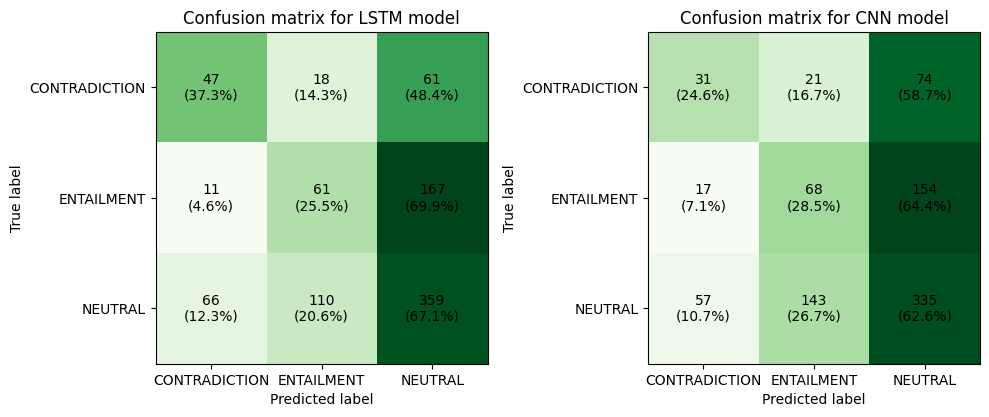

In [26]:
# Définir les noms de classe
class_names = ['CONTRADICTION', 'ENTAILMENT', 'NEUTRAL']
# Convertir les étiquettes de test en étiquettes de classe
Y_test = to_categorical(test_labels, num_classes=len(class_names))
# Initialiser les figures pour les matrices de confusion
fig, axs = plt.subplots(nrows=1, ncols=len(models), figsize=(10, 5))
# Obtention des prédictions et du F1-score pour chaque modèle
for i, (name, model) in enumerate(models):
    # Obtenir les prédictions sur les données de test
    Y_pred = model.predict(test_sequences)
    # Convertir les prédictions en étiquettes de classe
    Y_pred = np.argmax(Y_pred, axis=1)
    # Convertir les étiquettes de test en étiquettes de classe
    Y_test_labels = np.argmax(Y_test, axis=1)
    # Créer une matrice de confusion
    cm = confusion_matrix(Y_test_labels, Y_pred)
    # Calculer la précision pour chaque classe et la stocker dans une liste
    precision = [cm[i][i] / max(1, sum(cm[:, i])) for i in range(cm.shape[1])]
    # Calculer la F1-score pour le modèle
    f1 = f1_score(Y_test_labels, Y_pred, average="macro")
    # Calculer les pourcentages dans la matrice de confusion
    denominator = cm.sum(axis=1)[:, np.newaxis]
    denominator[denominator == 0] = 1  # Remplacer les zéros par des uns
    cm_perc = cm.astype('float') / denominator
    # Afficher la matrice de confusion avec matplotlib
    im = axs[i].imshow(cm_perc, interpolation='nearest', cmap=plt.cm.Greens)
    axs[i].set_xticks(np.arange(len(class_names)))
    axs[i].set_yticks(np.arange(len(class_names)))
    axs[i].set_xticklabels(class_names)
    axs[i].set_yticklabels(class_names)
    axs[i].set_xlabel("Predicted label")
    axs[i].set_ylabel("True label")
    axs[i].set_title(f"Confusion matrix for {name} model")
    # Afficher les valeurs dans la matrice de confusion
    for j in range(len(class_names)):
        for k in range(len(class_names)):
            value = f"{cm[j, k]:.0f}\n({cm_perc[j, k]*100:.1f}%)"
            axs[i].text(k, j, value, ha='center', va='center', color='black')
    # Afficher le F1-score et la précision pour chaque classe
    print(f"{name} F1-Score: {f1:.3f}")
    for j in range(len(class_names)):
        print(f"Precision for {class_names[j]}: {precision[j]*100:.1f}%")
# Sauvegarder la matrice de confusion comme image
fig.savefig(f"{output_data}matrix_conf_model.png")
# Afficher les figures
plt.tight_layout()
plt.show()

#### comparaison graphique de la performance du modèle

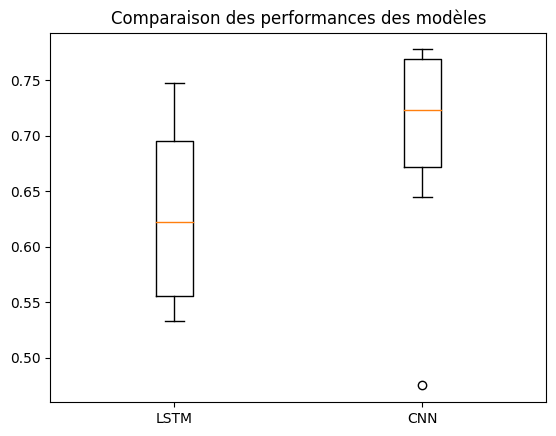

In [27]:
#Afficher un graphique comparant la performance des deux modèles
plt.boxplot(results, labels=names)
plt.title('Comparaison des performances des modèles')
plt.savefig(f"{output_data}comparaison_perf.png")
plt.show()

Le graphique de boîte à moustaches compare les performances de deux modèles (ici LSTM et CNN). Sur la boîte à moustache, nous avons la distribution des données de performance, où la ligne médiane est la médiane des données, la boîte inférieure représente le premier quartile des données (25%), la boîte supérieure représente le troisième quartile des données (75%), et les points à l'extérieur de la boîte sont des données aberrantes. Sur ce graphique ci-dessus, la boîte à moustaches du LSTM est beaucoup plus écrasée sur la médiane que celle du CNN, indiquant que les performances du LSTM sont plus cohérentes que celles de CNN. 

NB : 

- La cohérence observée dans les boite à moustaches sont sensible a la valeur des droptouts... A 0.2 les LTSM est plus cohérent alors que a 50% il n'y a presque pas de différences mais le CNN seul a des valeurs aberrantes et les cm sont plus cohérente

- De plus la valeur du n_splits du kfold (test entre 2 et 20) plus LSTM on des précisions cohérente tandis que celles du CNN ne s'écrase pas plus sur la médiane.

- Dans certains cas on a des valeurs aberrantes. Le fait qu'il y ait des données aberrantes pour les deux modèles indique que certains cas ont des performances considérablement meilleures ou moins bonnes que la médiane. Par exemple le point en dehors de la boîte pour le LSTM à ~0,49 indique un résultat assez mauvais, tandis que le point à ~0,60 montre une performance relativement bonne. Pour CNN, le point en dehors de la boîte à ~0,46 indique également un résultat assez mauvais, tandis que la boîte plus grande de CNN suggère une plus grande variabilité dans les performances.

#### entrainement et évaluation des modèles

In [28]:
# Entraîner et évaluer le meilleur modèle (LSTM)
best_model = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, input_length=maxlen),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
best_model.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model.fit(
    train_sequences, train_labels, epochs=100, batch_size=64, verbose=0)
loss, accuracy = best_model.evaluate(
    test_sequences, test_labels, verbose=0)
print("Accuracy:", accuracy)

Accuracy: 0.26555556058883667


J'ai fait varier les epochs entre 3 et 100. Cela n'a aucun effet sur la précision du modèle...

#### representation graphique des performances des modèles

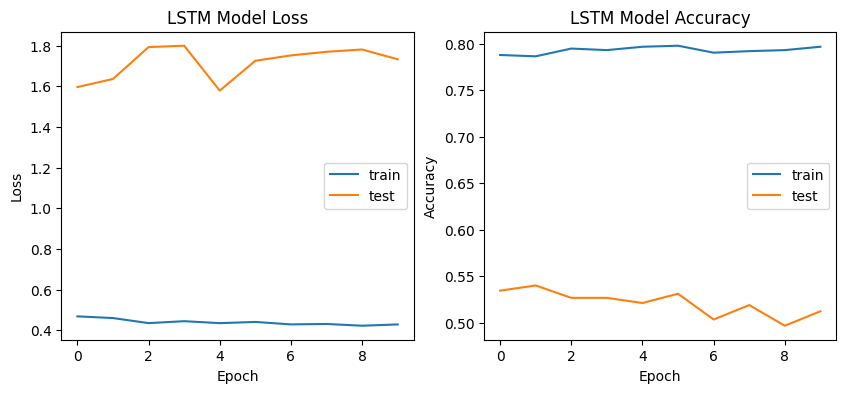

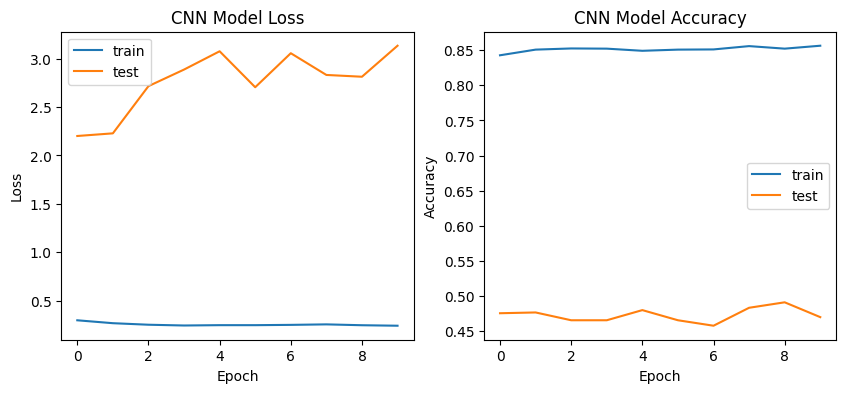

In [29]:
# Afficher le graphique de loss et accuracy par epoch pour chaque modèle
for name, model in models:
    history = model.fit(
        train_sequences, train_labels, epochs=10, batch_size=64, 
        validation_data=(test_sequences, test_labels), verbose=0
    )
    # Tracer la perte et la précision de l'entraînement et de la validation :
    #perte (loss)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title(name + ' Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    #précision (accuracy)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title(name + ' Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f"{output_data}{name}_accuracy_loss.png")
    plt.show()

Perspectives : 

Pour améliorer les modèles, on peut jouer sur les hyperparamètres tels que le dropout, le nombre de neurones, le nombre d'époques, le batch size, le nombre de filtres de la couche de convolution, etc. On peut également tajouter ou de supprimer des couches pour changer l'architecture du modèle.